### Getting the models and configurations from Github

In [ ]:
!git clone https://github.com/sai-phyo-hein/Hybrid_Transformer_for_Portfolio_Allocation.git
!pip install -q -r /content/Hybrid_Transformer_for_Portfolio_Allocation/requirements.txt

Cloning into 'Hybrid_Transformer_for_Portfolio_Allocation'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 343 (delta 150), reused 197 (delta 134), pack-reused 120
Receiving objects: 100% (343/343), 30.15 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (197/197), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.7 MB/s eta 0:00:00


In [ ]:
from Hybrid_Transformer_for_Portfolio_Allocation.data.eq_data_loader import get_eq_data
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_hybrid import hybrid_transformer_database
from Hybrid_Transformer_for_Portfolio_Allocation.data.data_prep_vanilla import vanilla_transformer_database

from Hybrid_Transformer_for_Portfolio_Allocation.models.hybrid_transformer_model import HybridTransformer_Portfolio
from Hybrid_Transformer_for_Portfolio_Allocation.models.benchmark_transformer_model import Transformer_Portfolio

import pandas as pd
import numpy as np
import tensorflow as tf
import json

import keras
keras.utils.set_random_seed(0)

### Data Loading

In [ ]:
data_config = json.load(open('/content/Hybrid_Transformer_for_Portfolio_Allocation/configs/data_config.json', 'r'))

In [ ]:
data = get_eq_data(
    '/content/Hybrid_Transformer_for_Portfolio_Allocation/data/nifty_50_metadata.csv',
    start = data_config['data_start_date'],
    end = data_config['data_end_date'],
    corr_thresh = data_config['correlation_thresh'],
    market_cap_filter = data_config['market_cap_filter']
)

[*********************100%%**********************]  50 of 50 completed


### Data Preparation

In this step, the data is splitted into train and test sets. Train dataset is again splitted into train and validataion in the next step. 30 data points at the start of test set is eliminated to prevent leakage from autocorrelation of the time series data.

In [ ]:
xtrain, xtest, ytrain, ytest, train_index, test_index = hybrid_transformer_database(
    data = data, timestep = 4, lag = 1, lagSD = 10, test_size= 0.2, purge_size = 30
)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(1979, 4, 34) (503, 4, 34) (1979, 17) (503, 17)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
cv_sharpe_thresh = 0.19
current_sharpe = 0

### Grid Search Validation for Best Hyperparameter

In [ ]:
from sklearn.model_selection import train_test_split

attention_numbers = [32, 128, 256]
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [64, 128, 256]
dropouts = [0.1, 0.05]

trainx_, valx, trainy_, valy = train_test_split(
    xtrain.numpy(), ytrain.numpy(), test_size = 0.2, shuffle = False
)

In [ ]:
model_performance = pd.DataFrame()

for an in attention_numbers:
    for lr in learning_rates:
        for bs in batch_sizes:
            for dp in dropouts:
                trainx = tf.convert_to_tensor(trainx_[:int(trainx_.shape[0] / bs) * bs, :, :], np.float32)
                trainy = tf.convert_to_tensor(trainy_[:trainx.shape[0], :], np.float32)

                model = HybridTransformer_Portfolio(trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = an, dropout= dp, learningRate = lr)
                model.allocation_hybrid_train(trainx, trainy, Epochs = 1, BatchSize = bs)

                eval_price = data.iloc[:xtrain.shape[0], :].iloc[-valx.shape[0] + 10:, :]
                eval_weights = model.allocation_hybrid_test(valx[10:, :])
                eval_mean = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).mean()
                eval_std = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).std()
                eval_sharpe = eval_mean / eval_std

                if eval_sharpe > cv_sharpe_thresh:
                    model.hybrid_save_weights('best_weights.h5') # whenever the evaluation sharpe ratio > threshold
                if eval_sharpe > current_sharpe:
                    current_sharpe = eval_sharpe
                    model.hybrid_save_weights('current_best.h5') # whenever the evaluation sharpe ratio > current best

                tf.keras.backend.clear_session()

                temp_performance = pd.DataFrame()
                temp_performance['attention_num'] = [an]
                temp_performance['learning_rate'] = [lr]
                temp_performance['batch_size'] = [bs]
                temp_performance['dropout'] = [dp]

                temp_performance['eval_mean'] = [eval_mean]
                temp_performance['eval_std'] = [eval_std]
                temp_performance['eval_sharpe_ratio'] = [eval_sharpe]
                model_performance = pd.concat([model_performance, temp_performance])

13/13 [==============================] - 1s 14ms/step


In [ ]:
model_performance.sort_values('eval_sharpe_ratio', ascending = False).head(1)

,attention_num,learning_rate,batch_size,dropout,eval_mean,eval_std,eval_sharpe_ratio
0,256,0.0001,128,0.05,0.002165,0.012302,0.175981


###

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
Dropout = 0.05
LearningRate = 0.01
Epochs = 100
BatchSize = 256
num_heads = 256

trainx = tf.convert_to_tensor(trainx_[:int(trainx_.shape[0] / BatchSize) * BatchSize, :, :], np.float32)
trainy = tf.convert_to_tensor(trainy_[:trainx.shape[0], :], np.float32)

best_model = HybridTransformer_Portfolio(
    trainx.shape[1], trainx.shape[2], outputShape = trainy.shape[1],  headsAttention = num_heads, dropout= Dropout, learningRate = LearningRate
)
best_model.hybrid_load_weights('current_best.h5') # use the pretrained weights to for reproducbilities

In [ ]:
### retrain with higher epoch
best_model.allocation_hybrid_train(trainx, trainy, Epochs = Epochs, BatchSize=BatchSize)

In [ ]:
eval_price = data.iloc[:xtrain.shape[0], :].iloc[-valx.shape[0] + 10:, :]
eval_weights = best_model.allocation_hybrid_test(valx[10:, :]) ## purge 10 datapoints
eval_mean = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).mean()
eval_std = (eval_price.pct_change().dropna() * eval_weights[1:, :]).sum(axis = 1).std()
eval_sharpe = eval_mean / eval_std
eval_mean, eval_std, eval_sharpe

13/13 [==============================] - 1s 16ms/step


(0.004636958711292922, 0.03046343805646312, 0.15221389991170564)

### Test on Test Set

In [ ]:
test_weights = best_model.allocation_hybrid_test(xtest)

16/16 [==============================] - 0s 15ms/step


In [ ]:
test_weights[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.013, 0.986,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
      dtype=float32)

In [ ]:
test_weights[1:-1, :]

array([[1.7886871e-06, 3.8062201e-06, 5.7538813e-07, ..., 8.8953465e-07,
        1.1248768e-05, 1.4301012e-06],
       [1.7886306e-06, 3.8061178e-06, 5.7535789e-07, ..., 8.8950060e-07,
        1.1248337e-05, 1.4300383e-06],
       [1.7884773e-06, 3.8058060e-06, 5.7527177e-07, ..., 8.8940232e-07,
        1.1247115e-05, 1.4298585e-06],
       ...,
       [1.7885333e-06, 3.8059834e-06, 5.7536164e-07, ..., 8.8944114e-07,
        1.1248744e-05, 1.4300573e-06],
       [1.7882794e-06, 3.8054757e-06, 5.7523056e-07, ..., 8.8927499e-07,
        1.1246954e-05, 1.4297957e-06],
       [1.7882251e-06, 3.8053636e-06, 5.7520379e-07, ..., 8.8923696e-07,
        1.1246612e-05, 1.4297481e-06]], dtype=float32)

In [ ]:
test_mean = ((data.loc[test_index, :].pct_change().dropna().iloc[1:, :] * test_weights[1:-1, :]).sum(axis = 1) - 0.01 * (test_weights[:-2, :] - test_weights[1:-1, :]).sum(axis = 1)).mean()
test_mean

0.0018072190730073485

In [ ]:
test_std = ((data.loc[test_index, :].pct_change().dropna().iloc[1:, :] * test_weights[1:-1, :]).sum(axis = 1) - 0.01 * (test_weights[:-2, :] - test_weights[1:-1, :]).sum(axis = 1)).std()
test_std

0.017385358874051408

In [ ]:
test_mean / test_std

0.10395063375451634

Text(0, 0.5, 'Cumulative Return')

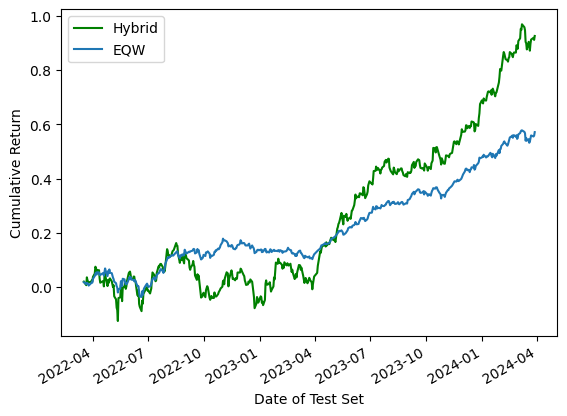

In [ ]:
import matplotlib.pyplot as plt
((data.loc[test_index, :].pct_change().dropna() * test_weights[:-1, :]).sum(axis = 1) ).cumsum().plot(color = 'green')
((data.loc[test_index, :].pct_change().dropna() * (np.ones(test_weights[1:, :].shape) / 17)).sum(axis = 1) ).cumsum().plot()
plt.legend(['Hybrid', 'EQW'])
plt.xlabel('Date of Test Set')
plt.ylabel('Cumulative Return')

In [ ]:
best_model.hybrid_save_weights('hybrid_model_trained_weights.h5')